In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets as gen_dataset

torch.manual_seed(1)

In [134]:
class Dataset(BaseDataset):

    def __init__(self, num_data_points = 100, num_clusters= 1 , cluster_std = 0.1):
        
        self.clusters = num_clusters
        centers = [[np.random.randn(),np.random.randn()] for i in range(num_clusters) ]
        self.X,self.y = gen_dataset.make_blobs(n_samples=num_data_points,random_state=1,centers=centers,cluster_std=cluster_std)
 
        
    def __getitem__(self, i):
        x_data = torch.Tensor(self.X[i])
        if self.clusters > 2:
            y_data =  torch.Tensor([1 if self.y[i] == j else 0 for j in range(self.clusters)]).long()
        else:
            y_data = torch.Tensor([self.y[i]])
#         print(y_data,self.y[i])
        return x_data,y_data
    
    def get_all_data(self):
        return self.X,self.y
    
    def visualize(self):
        plt.figure()
        for i in range(self.clusters):
            plt.scatter(self.X[self.y==i,0],self.X[self.y==i,1] )
        plt.show()
    
    def __len__(self):
        return len(self.y)

In [135]:
class my_model(nn.Module):
    def __init__(self, input_size = 1 , output_size = 1, num_layers = 1, width = 1):
        super().__init__()
        self.input_layer = nn.Linear(input_size,width)
        self.hidden_layer = nn.Linear(width,width)
        self.output_layer = nn.Linear(width,output_size)
    
        self.num_layers = num_layers
    def forward(self,x):
        x = F.relu(self.input_layer(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layer(x))
        pred = torch.sigmoid(self.output_layer(x))
        return pred
    
    def predict(self,x):
        pred = self.forward(x)
        if pred.shape[1] > 2:
            return np.argmax(pred.data.numpy(),axis=1)
        else:
            return [1 if p > 0.5 else 0 for p in pred ]


In [136]:
data = Dataset(num_data_points = 100, num_clusters= 2, cluster_std=0.7 )
data_loader = DataLoader(data ,100)
data.visualize()


In [ ]:
%matplotlib qt
output_size = data.clusters if data.clusters > 2 else 1

model = my_model(input_size = 2 ,output_size = output_size, num_layers = 2, width = 4)

if output_size  > 2:
    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCELoss()
    
optimizer = torch.optim.SGD(model.parameters() , lr = 0.1)

epochs = 2000
losses = []

fig, ax = plt.subplots(2, 1)
plt.tight_layout()

for i in range(epochs):
    for x,y in data_loader:
       
        y_pred = model.forward(x)
#         print( np.argmax(y,axis = 1), np.argmax(y_pred.data.numpy(), axis = 1) )
        if output_size > 2:
            loss = criterion( y_pred,  np.argmax(y,axis = 1) )
        else:
            loss = criterion( y_pred,y)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        
    if i%100 == 0:
        print(f'epoch:{i} loss:{loss.item()}')
#         y_pred = model.predict(x)
            
    if i%10 == 0:
        X = x.numpy()
        if output_size > 2:
            y = np.argmax(y,axis=1).numpy()
        else:
            y = y.view(1,-1).numpy()[0]


       
        ax[0].cla()
        ax[0].set_title(f'epoch:{i}')
        h = 0.02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


        Z = np.array(model.predict( torch.Tensor(np.c_[xx.ravel(), yy.ravel()])))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)

        ax[0].imshow(Z, interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect='auto', origin='lower')

        for i in range(data.clusters):
            ax[0].scatter(X[y==i,0],X[y==i,1] )

        ax[1].cla()
        ax[1].set_title(f'loss:{round(loss.item(),4)}')
        ax[1].plot(np.array(losses)/len(losses) )
        plt.pause(0.1)
    

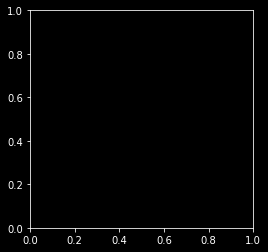

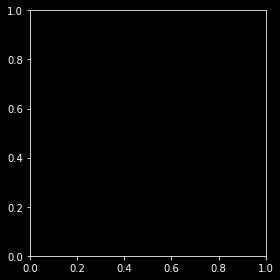

In [2]:
import PySimpleGUI as sg

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, FigureCanvasAgg
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets as gen_dataset
import inspect
import threading
import queue
import matplotlib.cm as cm

torch.manual_seed(1)
plt.style.use('dark_background')
sg.theme('Black')

class Dataset(BaseDataset):

    def __init__(self, num_data_points = 100, num_clusters= 1 , cluster_std = 0.1):
        
        self.clusters = num_clusters
        centers = [[np.random.randn(),np.random.randn()] for i in range(num_clusters) ]
        self.X,self.y = gen_dataset.make_blobs(n_samples=num_data_points,random_state=1,centers=centers,cluster_std=cluster_std)
 
        
    def __getitem__(self, i):
        x_data = torch.Tensor(self.X[i])
        if self.clusters > 2:
            y_data =  torch.Tensor([1 if self.y[i] == j else 0 for j in range(self.clusters)]).long()
        else:
            y_data = torch.Tensor([self.y[i]])
#         print(y_data,self.y[i])
        return x_data,y_data
    
    def get_all_data(self):
        return self.X,self.y
    
    def visualize(self):
        plt.figure()
        for i in range(self.clusters):
            plt.scatter(self.X[self.y==i,0],self.X[self.y==i,1] )
        plt.show()
    
    def __len__(self):
        return len(self.y)


class my_model(nn.Module):
    def __init__(self, input_size = 1 , output_size = 1, num_layers = 1, width = 1):
        super().__init__()
        self.input_layer = nn.Linear(input_size,width)
        self.hidden_layer = nn.Linear(width,width)
        self.output_layer = nn.Linear(width,output_size)
        self.num_layers = num_layers
        
    def forward(self,x):
        x = F.relu(self.input_layer(x))
        for i in range(self.num_layers):
            x = F.relu(self.hidden_layer(x))
        pred = torch.sigmoid(self.output_layer(x))
        return pred
    
    def predict(self,x):
        pred = self.forward(x)
        if pred.shape[1] > 2:
            return np.argmax(pred.data.numpy(),axis=1)
        else:
            return [1 if p > 0.5 else 0 for p in pred ]
    


def draw_figure(canvas, figure, loc=(0, 0)):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side='top', fill='both', expand=1)
    return figure_canvas_agg

def get_default_args(func):
    signature = inspect.signature(func)
    return {
        k: v.default
        for k, v in signature.parameters.items()
        if (v.default is not inspect.Parameter.empty) and (k != 'lr')
    }

xx,yy = '',''
Z = ''
def train_network(net_fig_queue,stop_training_queue ):
    global model
    data_loader = DataLoader(data ,data_points)

    neurons = int(values['neuron_slider'] )
    hidden_layers = int(values['hidden_slider'])
    learning_rate = float(values['lr_slider']) 
    epochs = int(values['epoch_slider'])

    output_size = data.clusters if data.clusters > 2 else 1

    model = my_model(input_size = 2 ,output_size = output_size, num_layers = hidden_layers, width = neurons)

    if output_size  > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()


    parameter_tuple = tuple(optimizer_parameter_dict[values['optimizer']].values())
    optimizer = getattr(torch.optim,values['optimizer'])(model.parameters(),learning_rate,*parameter_tuple)

    for i in range(epochs):
        for x,y in data_loader:

            y_pred = model.forward(x)
    #         print( np.argmax(y,axis = 1), np.argmax(y_pred.data.numpy(), axis = 1) )
            if output_size > 2:
                loss = criterion( y_pred,  np.argmax(y,axis = 1) )
            else:
                loss = criterion( y_pred,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        #if i%100 == 0:
            #print(f'epoch:{i} loss:{loss.item()}')
    #         y_pred = model.predict(x)
        try:
            train_terminate = stop_training_queue.get_nowait()
        except queue.Empty:
            train_terminate = None
        finally:
            if train_terminate:
                break

            elif i%int(values['plot_step']) == 0:
                
                epoch_num = i 
                X = x.numpy()
                if output_size > 2:
                    y = np.argmax(y,axis=1).numpy()
                else:
                    y = y.view(1,-1).numpy()[0]

                net_plot.cla()
                net_plot.set_title(f'epoch:{i}')
                h = 0.02
                x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
                y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
                global xx,yy,Z
                xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


                Z = np.array(model.predict( torch.Tensor(np.c_[xx.ravel(), yy.ravel()])))
                # Put the result into a color plot
                Z = Z.reshape(xx.shape)

                
            
                colors = cm.seismic(np.linspace(0, 1, data.clusters))
                for i,c in zip(range(data.clusters),colors):
                    net_plot.scatter(X[y==i,0],X[y==i,1],color = c )


                loss_plot.cla()
            #             loss_plot.draw_artist(loss_plot.patch)
                loss_plot.set_title(f'loss:{round(losses[-1],4)}')
                loss_plot.set_yticklabels([])
                loss_plot.plot(np.array(losses) )
                        
    
                net_fig_queue.put(1)
    
        

    window['stop_training'].update(disabled = True)




text_len= len('GOOEY Neural Nets: Function Approximators')
data_frame_text_len = len('Number of clusters:')
model_frame_text_len = len('Number of neurons in layer:')
optimizer_list = [optimizer for optimizer in  dir(torch.optim) if (optimizer not in ['Optimizer','lr_scheduler']) and ('__' not in optimizer  ) ]
max_optim_len = max([len(string) for string in optimizer_list]) + 1
optimizer_parameter_dict = {optimizer:get_default_args(getattr(torch.optim,optimizer)) for optimizer in optimizer_list }
initial_optim_params_list = list( optimizer_parameter_dict[optimizer_list[0]] )
init_params_dict = optimizer_parameter_dict[optimizer_list[0]]
max_optim_len = max([len(string) for string in optimizer_list])


layout = [

    [sg.Text('GOOEY Neural Nets: Logistic Regression', size=(text_len, 1), justification='center', font=("Defau", 25), relief=sg.RELIEF_RIDGE)],
    
    [sg.Frame(layout = [
    
        [sg.Text('Datapoints:',size = (data_frame_text_len,1)), sg.Slider(default_value = 1000,range=(0, 100000), size=(60, 20), orientation='h', key='data_slider')],
        [sg.Text('noise in data:',size = (data_frame_text_len,1)), sg.Slider(default_value = 0.5,range=(0, 100) , resolution = 0.1, size=(60, 20), orientation='h', key='noise_slider')],
        [sg.Text('Number of clusters:',size = (data_frame_text_len,1)) , sg.DropDown(values = list(range(1,11)) , default_value = 2, size = (5,1),key='cluster_slider' ) ]
        
    
    ], relief = sg.RELIEF_SUNKEN , title = 'DATA'  )   ],
    
    [sg.Frame(layout = [
    
        [sg.Text('Number of neurons in layer:',size = (model_frame_text_len,1) ),sg.Slider(default_value = 2, range=(1, 100), size=(60, 20), orientation='h', key='neuron_slider')     ],
        [sg.Text('Number of hidden layers:',size = (model_frame_text_len,1)),sg.Slider(default_value = 2,range=(1, 100), size=(60, 20), orientation='h', key='hidden_slider')     ],
        [sg.Text('Learning Rate:',size = (model_frame_text_len,1)) ,sg.Slider(default_value = 0.01,range=(0, 10),resolution=0.01, size=(60, 20), orientation='h', key='lr_slider')    ],
        [sg.Text('Epochs:',size = (model_frame_text_len,1)),sg.Slider(default_value = 1000,range=(0, 10000),resolution=1, size=(60, 20), orientation='h', key='epoch_slider')     ],
        [sg.Text('Optimizers:',size = (model_frame_text_len,1)),sg.DropDown(values = optimizer_list , default_value = optimizer_list[0],enable_events = True, key = 'optimizer',size = (max_optim_len,1))],
        [sg.Text('Optimizer parameters:',size = (model_frame_text_len,1)), sg.DropDown(values = initial_optim_params_list, default_value = initial_optim_params_list[0], enable_events = True  , key ='optimizer_params')],
        [sg.Text('parameter value:',size = (model_frame_text_len,1)),sg.Input( init_params_dict[ initial_optim_params_list[0]],tooltip = 'Enter in format shown', key = 'param_value',size = (10,1)) , sg.Text(type(init_params_dict[ initial_optim_params_list[0]]),key='param_type' ) , sg.Button('Update',key = 'update') ,sg.Button('reset all',key = 'reset')]
        
        
    
    ], relief = sg.RELIEF_SUNKEN , title = 'MODEL'  )   ],
    
    [sg.Button('Generate Data',key = 'gen_data'),sg.Button('Start Training',disabled=True,key = 'train_net'), sg.Text('Plot step size:') , sg.DropDown(values = list(range(0,1000,10)) ,default_value= 10,key = 'plot_step' ) ,sg.Button('Stop Training' , disabled = True, key = 'stop_training') ],
    [sg.Canvas( size = (100,100) , key = 'net_canvas' ),sg.Canvas( size = (100,100) , key = 'loss_canvas' )],
    
    
    [sg.Button('Exit')]
]      

window = sg.Window('GOOEY Neural Nets', layout , finalize = True) 

# net canvas
net_canvas_elem = window['net_canvas']
net_canvas = net_canvas_elem.TKCanvas

net_fig = plt.figure(figsize=(4,4))
net_plot = net_fig.add_subplot(111)
# net_plot.grid()
net_fig_agg = draw_figure(net_canvas, net_fig)

# loss canvas
loss_canvas_elem = window['loss_canvas']
loss_canvas = loss_canvas_elem.TKCanvas

loss_fig = plt.figure(figsize=(4,4))
loss_plot = loss_fig.add_subplot(111)
# loss_plot.grid()
loss_fig_agg = draw_figure(loss_canvas, loss_fig)

plt.tight_layout()

draw_signal = queue.Queue()
stop_training = queue.Queue()

# =======
model = ''
criterion = ''
optimizer = ''
epochs = ''

losses = []

data_points = 0
data = ''
#===========
while 1:
    event, values = window.read(timeout = 100)    
    if event == 'Exit':
        stop_training.put(1)
        window.close()
        break
    elif event == 'optimizer':
        
         window['optimizer_params'].update( values= list( optimizer_parameter_dict[ values['optimizer'] ] ) ) 

    elif event == 'optimizer_params':
        
        current_param_type = type(optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']])
        window['param_type'].update(current_param_type if current_param_type != int else float)
        param_value = optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']]
        window['param_value'].update( param_value if current_param_type != int else float(param_value) )
       
        
    elif event == 'update':
        current_param_type = type( optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']] )
        new_value = ''
        if current_param_type == tuple:
            indiv_type = type(optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']][0])
            if len(values['param_value'].split()) != 2:
                print('incorrect input')
            else:
                new_value = ( indiv_type(values['param_value'].split()[0]) , indiv_type(values['param_value'].split()[1]) )
                optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']] = new_value
        else:
            try:
                new_value = current_param_type(values['param_value'])
                optimizer_parameter_dict[ values['optimizer'] ][values['optimizer_params']] = new_value
            except:
                print('incorrect input')
                
#         
        
    elif event == 'gen_data':
        
        net_plot.cla()                    # clear the subplot
#         net_plot.grid()                   # draw the grid
        
        data_points = int(values['data_slider']) # draw this many data points (on next line)
        noise =  float(values['noise_slider'])
        num_clusters = int(values['cluster_slider'])
        
        data = Dataset(num_data_points = data_points, num_clusters = num_clusters , cluster_std = noise)
        X,y = data.get_all_data()
        
        colors = cm.seismic(np.linspace(0, 1, data.clusters))
        for i,c in zip(range(data.clusters),colors):
            net_plot.scatter(X[y==i,0],X[y==i,1],color = c )
        
        net_fig_agg.draw()
        window['train_net'].update(disabled = False)
        
        
    elif event == 'train_net':
        losses = []
        t1 = threading.Thread(target=train_network , args = (draw_signal,stop_training) , daemon = True)
        t1.start()
        window['stop_training'].update(disabled = False)
    elif event =='stop_training':  
        stop_training.put(1)
        window['stop_training'].update(disabled = True)
        
            
    try:
        draw_status = draw_signal.get_nowait()
    except queue.Empty:
        draw_status = None
    
    if draw_status:
        
        net_plot.imshow(Z, interpolation='nearest',
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                cmap = plt.cm.Dark2,
                aspect='auto', origin='lower')
        net_fig_agg.flush_events()
        net_fig_agg.draw()
    
        loss_fig_agg.flush_events()
        loss_fig_agg.draw()
        
        


        



In [2]:
window.close()